In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shap
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_crashes = pd.read_csv('/content/drive/MyDrive/Phase4/Project/P4Dataset/Refined_Traffic_Crashes_-_Crashes_20250412.csv', low_memory=False)
df_people = pd.read_csv('/content/drive/MyDrive/Phase4/Project/P4Dataset/df_people_cleaned.csv', low_memory=False)
df_vehicles = pd.read_csv('/content/drive/MyDrive/Phase4/Project/P4Dataset/df_vehicles_cleaned.csv', low_memory=False)

In [4]:
#lets focus only on drivers
df_people1=df_people[df_people["PERSON_TYPE"]=="DRIVER"]

# Data Cleaning

In [5]:
df_driver = pd.merge(df_vehicles, df_people1, on='CRASH_RECORD_ID', how='inner')

In [6]:
#joining the crash dataframe to the new dataframe
merged_df = pd.merge(df_crashes, df_driver, on='CRASH_RECORD_ID', how='inner')


## Target Grouping

In [7]:
merged_df["PRIM_CONTRIBUTORY_CAUSE"].unique()

array(['FAILING TO YIELD RIGHT-OF-WAY', 'UNABLE TO DETERMINE',
       'IMPROPER TURNING/NO SIGNAL', 'DISREGARDING TRAFFIC SIGNALS',
       'IMPROPER BACKING', 'FOLLOWING TOO CLOSELY',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'IMPROPER OVERTAKING/PASSING', 'TURNING RIGHT ON RED',
       'IMPROPER LANE USAGE', 'NOT APPLICABLE',
       'DRIVING ON WRONG SIDE/WRONG WAY', 'DISREGARDING STOP SIGN',
       'DISREGARDING ROAD MARKINGS',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'WEATHER', 'EQUIPMENT - VEHICLE CONDITION',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'PHYSICAL CONDITION OF DRIVER',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'DISTRACTION - FROM INSIDE VEHICLE', 'ANIMAL',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'CELL PHONE USE OTH

In [8]:
#changing the y to fewer levels
cause_map = {
    #  Driver Behavior
    'FOLLOWING TOO CLOSELY': 'Driver Behavior',
    'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Driver Behavior',
    'IMPROPER BACKING': 'Driver Behavior',
    'IMPROPER TURNING/NO SIGNAL': 'Driver Behavior',
    'IMPROPER LANE USAGE': 'Driver Behavior',
    'IMPROPER OVERTAKING/PASSING': 'Driver Behavior',
    'DRIVING ON WRONG SIDE/WRONG WAY': 'Driver Behavior',
    'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Driver Behavior',
    'EXCEEDING AUTHORIZED SPEED LIMIT': 'Driver Behavior',
    'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Driver Behavior',

    # Distraction
    'DISTRACTION - FROM INSIDE VEHICLE': 'Distraction',
    'DISTRACTION - FROM OUTSIDE VEHICLE': 'Distraction',
    'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)': 'Distraction',
    'TEXTING': 'Distraction',
    'CELL PHONE USE OTHER THAN TEXTING': 'Distraction',

    # Traffic Rule Violations
    'FAILING TO YIELD RIGHT-OF-WAY': 'Traffic Violations',
    'DISREGARDING OTHER TRAFFIC SIGNS': 'Traffic Violations',
    'DISREGARDING TRAFFIC SIGNALS': 'Traffic Violations',
    'DISREGARDING ROAD MARKINGS': 'Traffic Violations',
    'DISREGARDING STOP SIGN': 'Traffic Violations',
    'DISREGARDING YIELD SIGN': 'Traffic Violations',
    'TURNING RIGHT ON RED': 'Traffic Violations',

    # Environmental Factors
    'WEATHER': 'Environment',
    'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'Environment',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'Environment',
    'ROAD CONSTRUCTION/MAINTENANCE': 'Environment',
    'OBSTRUCTED CROSSWALKS': 'Environment',

    # Substance Use
    'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Substance Use',
    'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Substance Use',

    #Vehicle/Driver Condition
    'EQUIPMENT - VEHICLE CONDITION': 'Vehicle or Driver Condition',
    'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Vehicle or Driver Condition',
    'PHYSICAL CONDITION OF DRIVER': 'Vehicle or Driver Condition',

    #Other / Unusual Situations
    'RELATED TO BUS STOP': 'Other or Unusual',
    'PASSING STOPPED SCHOOL BUS': 'Other or Unusual',
    'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST': 'Other or Unusual',
    'ANIMAL': 'Other or Unusual',
    'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other or Unusual',
    'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other or Unusual',

    #Unknown / Not Applicable
    'UNABLE TO DETERMINE': 'Unknown/NA',
    'NOT APPLICABLE': 'Unknown/NA'
}

# Apply the mapping
merged_df["PRIM_CONTRIBUTORY_CAUSE"]= merged_df["PRIM_CONTRIBUTORY_CAUSE"].map(cause_map)

## Missing Values

In [9]:
merged_df.isna().mean()*100

,0
CRASH_RECORD_ID,0.000000
CRASH_DATE,0.000000
POSTED_SPEED_LIMIT,0.000000
TRAFFIC_CONTROL_DEVICE,0.000000
DEVICE_CONDITION,0.000000
WEATHER_CONDITION,0.000000
LIGHTING_CONDITION,0.000000
FIRST_CRASH_TYPE,0.000000
TRAFFICWAY_TYPE,0.000000
ROADWAY_SURFACE_COND,0.000000


In [10]:
merged_df = merged_df.loc[:, merged_df.isna().mean() <= 0.9]

In [11]:
merged_df = merged_df.dropna()

## Feature grouping & reduction

In [12]:
merged_df['TRAFFIC_CONTROL_DEVICE'].unique()

array(['STOP SIGN/FLASHER', 'NO CONTROLS', 'TRAFFIC SIGNAL', 'UNKNOWN',
       'OTHER', 'PEDESTRIAN CROSSING SIGN', 'RR CROSSING SIGN', 'YIELD',
       'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'SCHOOL ZONE',
       'RAILROAD CROSSING GATE', 'OTHER RAILROAD CROSSING',
       'FLASHING CONTROL SIGNAL', 'POLICE/FLAGMAN', 'DELINEATORS',
       'LANE USE MARKING', 'NO PASSING', 'BICYCLE CROSSING SIGN'],
      dtype=object)

In [13]:
#reducing the number of levels
control_map = {
    'PEDESTRIAN CROSSING SIGN': 'Pedestrian Control',
    'BICYCLE CROSSING SIGN': 'Pedestrian Control',
    'SCHOOL ZONE': 'Pedestrian Control',

    'RAILROAD CROSSING GATE': 'Railroad Control',
    'RR CROSSING SIGN': 'Railroad Control',
    'OTHER RAILROAD CROSSING': 'Railroad Control',

    'DELINEATORS': 'Other'
}
merged_df['TRAFFIC_CONTROL_DEVICE'] = merged_df['TRAFFIC_CONTROL_DEVICE'].map(control_map)

In [14]:
merged_df['FIRST_CRASH_TYPE'].unique()

array(['ANGLE', 'FIXED OBJECT', 'TURNING', 'REAR TO FRONT',
       'PARKED MOTOR VEHICLE', 'SIDESWIPE OPPOSITE DIRECTION', 'REAR END',
       'SIDESWIPE SAME DIRECTION', 'PEDALCYCLIST', 'HEAD ON',
       'OTHER OBJECT', 'PEDESTRIAN', 'REAR TO SIDE', 'REAR TO REAR',
       'ANIMAL', 'OVERTURNED', 'OTHER NONCOLLISION', 'TRAIN'],
      dtype=object)

In [15]:
crash_type_map = {
    # Vehicle-to-Vehicle
    'REAR END': 'Vehicle Collision',
    'HEAD ON': 'Vehicle Collision',
    'ANGLE': 'Vehicle Collision',
    'TURNING': 'Vehicle Collision',
    'SIDESWIPE SAME DIRECTION': 'Vehicle Collision',
    'SIDESWIPE OPPOSITE DIRECTION': 'Vehicle Collision',
    'REAR TO FRONT': 'Vehicle Collision',
    'REAR TO REAR': 'Vehicle Collision',
    'REAR TO SIDE': 'Vehicle Collision',

    # Vulnerable Road Users
    'PEDESTRIAN': 'Vulnerable User',
    'PEDALCYCLIST': 'Vulnerable User',

    # Stationary or Object
    'FIXED OBJECT': 'Fixed Object',
    'PARKED MOTOR VEHICLE': 'Fixed Object',
    'OTHER OBJECT': 'Fixed Object',
    'OTHER NONCOLLISION': 'Fixed Object',

    # Other or Special Cases
    'TRAIN': 'Special',
    'ANIMAL': 'Special',
    'OVERTURNED': 'Special'
}
merged_df['FIRST_CRASH_TYPE'] = merged_df['FIRST_CRASH_TYPE'].map(crash_type_map)

In [16]:
merged_df['TRAFFICWAY_TYPE'].unique()

array(['NOT DIVIDED', 'RAMP', 'FOUR WAY', 'DIVIDED - W/MEDIAN BARRIER',
       'PARKING LOT', 'DIVIDED - W/MEDIAN (NOT RAISED)', 'UNKNOWN',
       'Y-INTERSECTION', 'ONE-WAY', 'OTHER', 'ROUNDABOUT',
       'UNKNOWN INTERSECTION TYPE', 'T-INTERSECTION',
       'FIVE POINT, OR MORE', 'ALLEY', 'TRAFFIC ROUTE', 'NOT REPORTED',
       'CENTER TURN LANE', 'DRIVEWAY', 'L-INTERSECTION'], dtype=object)

In [17]:
intersection_map = {
    # Common intersections
    'FOUR WAY': 'Intersection',
    'T-INTERSECTION': 'Intersection',
    'Y-INTERSECTION': 'Intersection',
    'L-INTERSECTION': 'Intersection',
    'FIVE POINT, OR MORE': 'Intersection',
    'ROUNDABOUT': 'Intersection',

    # Divided roads
    'DIVIDED - W/MEDIAN BARRIER': 'Divided Road',
    'DIVIDED - W/MEDIAN (NOT RAISED)': 'Divided Road',

    # Non-divided
    'NOT DIVIDED': 'Undivided Road',
    'ONE-WAY': 'Undivided Road',
    'CENTER TURN LANE': 'Undivided Road',

    # Special or non-road spaces
    'PARKING LOT': 'Other Road Environment',
    'RAMP': 'Other Road Environment',
    'ALLEY': 'Other Road Environment',
    'DRIVEWAY': 'Other Road Environment',
    'TRAFFIC ROUTE': 'Other Road Environment',

    # Unknowns & misc
    'UNKNOWN': 'Unknown',
    'UNKNOWN INTERSECTION TYPE': 'Unknown',
    'NOT REPORTED': 'Unknown',
    'OTHER': 'Other'
}
merged_df['TRAFFICWAY_TYPE'] = merged_df['TRAFFICWAY_TYPE'].map(intersection_map)

In [18]:
merged_df['SEX'].unique()
merged_df['SEX'] = merged_df['SEX'].replace('X', 'Unspecified')

In [19]:
merged_df['DRIVER_ACTION'].unique()

array(['FAILED TO YIELD', 'NONE', 'IMPROPER TURN', 'IMPROPER BACKING',
       'DISREGARDED CONTROL DEVICES', 'UNKNOWN', 'FOLLOWED TOO CLOSELY',
       'IMPROPER PARKING', 'OTHER', 'OVERCORRECTED',
       'IMPROPER LANE CHANGE', 'EMERGENCY VEHICLE ON CALL',
       'TOO FAST FOR CONDITIONS', 'IMPROPER PASSING', 'WRONG WAY/SIDE',
       'STOPPED SCHOOL BUS', 'CELL PHONE USE OTHER THAN TEXTING',
       'EVADING POLICE VEHICLE', 'TEXTING', 'LICENSE RESTRICTIONS'],
      dtype=object)

In [20]:
driver_action_map = {
    # Common driving violations
    'FAILED TO YIELD': 'Failure to Yield',
    'DISREGARDED CONTROL DEVICES': 'Traffic Violation',
    'WRONG WAY/SIDE': 'Traffic Violation',
    'STOPPED SCHOOL BUS': 'Traffic Violation',

    # Speed and spacing
    'TOO FAST FOR CONDITIONS': 'Unsafe Speed',
    'FOLLOWED TOO CLOSELY': 'Unsafe Speed',

    # Maneuver-related
    'IMPROPER TURN': 'Improper Maneuver',
    'IMPROPER LANE CHANGE': 'Improper Maneuver',
    'IMPROPER BACKING': 'Improper Maneuver',
    'IMPROPER PASSING': 'Improper Maneuver',
    'IMPROPER PARKING': 'Improper Maneuver',
    'OVERCORRECTED': 'Improper Maneuver',

    # Distraction
    'TEXTING': 'Distracted',
    'CELL PHONE USE OTHER THAN TEXTING': 'Distracted',

    # Legal / unusual edge cases
    'LICENSE RESTRICTIONS': 'Legal Issue',
    'EMERGENCY VEHICLE ON CALL': 'Special Vehicle Action',
    'EVADING POLICE VEHICLE': 'Evasive/Illegal Action',

    # General
    'NONE': 'None',
    'UNKNOWN': 'Unknown',
    'OTHER': 'Other'
}
merged_df['DRIVER_ACTION'] = merged_df['DRIVER_ACTION'].map(driver_action_map)

In [21]:
merged_df['DRIVER_VISION'].unique()

array(['NOT OBSCURED', 'UNKNOWN', 'PARKED VEHICLES', 'OTHER',
       'MOVING VEHICLES', 'WINDSHIELD (WATER/ICE)', 'BLINDED - SUNLIGHT',
       'SIGNBOARD', 'BUILDINGS', 'TREES, PLANTS', 'BLINDED - HEADLIGHTS',
       'BLOWING MATERIALS', 'EMBANKMENT', 'HILLCREST'], dtype=object)

In [22]:
driver_vision_map = {
    'NOT OBSCURED': 'Clear Vision',
    'UNKNOWN': 'Unknown',
    'OTHER': 'Other',

    # Light-related visibility issues
    'BLINDED - SUNLIGHT': 'Glare',
    'BLINDED - HEADLIGHTS': 'Glare',

    # Environmental/material obstruction
    'BLOWING MATERIALS': 'Environmental Obstruction',
    'WINDSHIELD (WATER/ICE)': 'Environmental Obstruction',

    # Physical/static object obstruction
    'MOVING VEHICLES': 'Vehicle Obstruction',
    'PARKED VEHICLES': 'Vehicle Obstruction',
    'HILLCREST': 'Physical Obstruction',
    'TREES, PLANTS': 'Physical Obstruction',
    'BUILDINGS': 'Physical Obstruction',
    'SIGNBOARD': 'Physical Obstruction',
    'EMBANKMENT': 'Physical Obstruction'
}
merged_df['DRIVER_VISION'] = merged_df['DRIVER_VISION'].map(driver_vision_map)

In [23]:
sec_cause_map = {
    'DISTRACTION - FROM INSIDE VEHICLE': 'Distraction',
    'DISTRACTION - FROM OUTSIDE VEHICLE': 'Distraction',
    'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)': 'Distraction',
    'TEXTING': 'Distraction',
    'CELL PHONE USE OTHER THAN TEXTING': 'Distraction',
    'UNABLE TO DETERMINE': 'Unknown/NA',
    'NOT APPLICABLE': 'Unknown/NA',
    'WEATHER': 'Environment',
    'ROAD CONSTRUCTION/MAINTENANCE': 'Environment',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'Environment',
    'FAILING TO YIELD RIGHT-OF-WAY': 'Traffic Violations',
    'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Traffic Violations',
    'DISREGARDING STOP SIGN': 'Traffic Violations',
    'DISREGARDING TRAFFIC SIGNALS': 'Traffic Violations',
    'DISREGARDING YIELD SIGN': 'Traffic Violations',
    'DISREGARDING ROAD MARKINGS': 'Traffic Violations',
    'DISREGARDING OTHER TRAFFIC SIGNS': 'Traffic Violations',
    'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Driver Behavior',
    'IMPROPER TURNING/NO SIGNAL': 'Driver Behavior',
    'IMPROPER OVERTAKING/PASSING': 'Driver Behavior',
    'FOLLOWING TOO CLOSELY': 'Driver Behavior',
    'IMPROPER LANE USAGE': 'Driver Behavior',
    'DRIVING ON WRONG SIDE/WRONG WAY': 'Driver Behavior',
    'IMPROPER BACKING': 'Driver Behavior',
    'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Driver Behavior',
    'EXCEEDING AUTHORIZED SPEED LIMIT': 'Driver Behavior',
    'TURNING RIGHT ON RED': 'Driver Behavior',
    'PASSING STOPPED SCHOOL BUS': 'Driver Behavior',
    'EQUIPMENT - VEHICLE CONDITION': 'Vehicle or Driver Condition',
    'PHYSICAL CONDITION OF DRIVER': 'Vehicle or Driver Condition',
    'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Substance Use',
    'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Substance Use',
    'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Driver Behavior',
    'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'Environment',
    'EMERGENCY VEHICLE ON CALL': 'Other or Unusual',
    'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST': 'Other or Unusual',
    'ANIMAL': 'Other or Unusual',
    'RELATED TO BUS STOP': 'Other or Unusual',
    'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other or Unusual',
    'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other or Unusual',
    'OBSTRUCTED CROSSWALKS': 'Other or Unusual',
}
merged_df['SEC_CONTRIBUTORY_CAUSE'] = merged_df['SEC_CONTRIBUTORY_CAUSE'].map(sec_cause_map)


In [24]:
selectedcolumns= ['CRASH_RECORD_ID',
                  'CRASH_DATE'
]

merged_df = merged_df.drop(columns=[col for col in selectedcolumns if col in merged_df.columns])


In [25]:
unique_counts = merged_df.nunique().sort_values(ascending=False)

print("Columns and their number of unique values:\n")
print(unique_counts)


Columns and their number of unique values:

LOCATION                   248066
BEAT_OF_OCCURRENCE            271
VEHICLE_YEAR                  230
AGE                           114
POSTED_SPEED_LIMIT             46
MANEUVER                       28
CRASH_HOUR                     24
VEHICLE_TYPE                   21
VEHICLE_DEFECT                 17
NUM_UNITS                      16
WEATHER_CONDITION              12
PHYSICAL_CONDITION             12
CRASH_MONTH                    12
DRIVER_ACTION                  11
DEVICE_CONDITION                8
SEC_CONTRIBUTORY_CAUSE          8
PRIM_CONTRIBUTORY_CAUSE         8
ROAD_DEFECT                     7
ROADWAY_SURFACE_COND            7
CRASH_DAY_OF_WEEK               7
DRIVER_VISION                   7
TRAFFICWAY_TYPE                 6
LIGHTING_CONDITION              6
FIRST_CRASH_TYPE                4
BAC_RESULT                      4
TRAFFIC_CONTROL_DEVICE          3
SEX                             3
PERSON_TYPE                     1
dtyp

In [26]:
# Drop high-cardinality columns
merged_df = merged_df.drop(columns=['LOCATION', 'BEAT_OF_OCCURRENCE'])

# Bin VEHICLE_YEAR
merged_df['VEHICLE_YEAR_BINNED'] = pd.cut(
    merged_df['VEHICLE_YEAR'],
    bins=[0, 1999, 2009, 2015, 2025],
    labels=['<2000', '2000-2009', '2010-2015', '2016+']
)

# Bin AGE
merged_df['AGE_BINNED'] = pd.cut(
    merged_df['AGE'],
    bins=[0, 18, 25, 35, 50, 65, 100],
    labels=['<18', '18–25', '26–35', '36–50', '51–65', '65+']
)

# Drop original high-cardinality columns
merged_df = merged_df.drop(columns=['VEHICLE_YEAR', 'AGE'])


In [27]:
df_clean = merged_df

In [28]:
# get the numeric cols and the cat cols
num_original_columns = df_clean.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_clean.select_dtypes(exclude=np.number).columns.tolist()

print("Categorical columns:", categorical_cols)
num_original_columns

Categorical columns: ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'MANEUVER', 'PERSON_TYPE', 'SEX', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'VEHICLE_YEAR_BINNED', 'AGE_BINNED']


['POSTED_SPEED_LIMIT',
 'NUM_UNITS',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH']

# ANN

### Encoding

The target variable was highly imbalanced, with some classes dominating the dataset.

To avoid bias toward majority classes, Random OverSampling was applied:

*   Used RandomOverSampler
*   Oversampled only the training data to avoid data leakage
*   Balanced all classes to have approximately equal representation

In [29]:
df_filter = df_clean[df_clean['PRIM_CONTRIBUTORY_CAUSE'] != 'Unknown/NA'].copy()

X = df_filter.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = df_filter['PRIM_CONTRIBUTORY_CAUSE']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [30]:
from sklearn.compose import ColumnTransformer

def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        output_features.extend(names)
    return output_features

feature_names = get_feature_names(preprocessor)


In [31]:
le = LabelEncoder()
le.fit(y)
#class mappings
class_names = le.classes_
print(class_names)


['Distraction' 'Driver Behavior' 'Environment' 'Other or Unusual'
 'Substance Use' 'Traffic Violations' 'Vehicle or Driver Condition']


In [32]:
X_train_scaled = np.nan_to_num(X_train_processed, nan=0.0)
X_test_scaled = np.nan_to_num(X_test_processed, nan=0.0)


In [33]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

print("After Resampling (Full):", Counter(y_train_resampled))


max_size = 150_000
if X_train_resampled.shape[0] > max_size:
    idx = np.random.choice(X_train_resampled.shape[0], max_size, replace=False)
    X_train_resampled = X_train_resampled[idx]
    y_train_resampled = y_train_resampled[idx]

print("After Resampling (Capped):", Counter(y_train_resampled))


After Resampling (Full): Counter({np.int64(5): 650903, np.int64(1): 650903, np.int64(4): 650903, np.int64(2): 650903, np.int64(0): 650903, np.int64(6): 650903, np.int64(3): 650903})
After Resampling (Capped): Counter({np.int64(5): 21618, np.int64(1): 21583, np.int64(0): 21503, np.int64(6): 21392, np.int64(3): 21335, np.int64(4): 21298, np.int64(2): 21271})


In [34]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)

class_weights = dict(enumerate(class_weights_array))

### Model Building
Multiple architectures and training configurations were tested. The iterations are explained below


1.  **Baseline ANN**

Architecture: 256 → 128 (ReLU) → softmax

Regularization: Dropout (0.3, 0.2)

Training: 20 epochs, batch size = 64

Limitations: Mild overfitting, limited depth, and small batch size led to suboptimal performance.


2.   **Larger Batch Size**

Batch size increased to 256 for more stable gradient updates. Slight performance improvement but overfitting still evident.


3.   **Batch Normalization & Early Stopping**

Added BatchNormalization after each dense layer

EarlyStopping introduced to avoid overfitting

Learning rate reduced to 0.0001, training extended to 100 epochs

Resulted in better generalization and more stable learning.

4.  **Deeper Network + Resampled Data**

Architecture: 512 → 256 → 128 → 64 → softmax

Dropout increased (0.3 → 0.2) for stronger regularization

Training on resampled data to address class imbalance

Hyperparameters tuned:

*   Learning rate: 0.0002
*   Batch size: 512
*   Patience: 5


5.   **Final Model: Cross-Validated ANN**

Introduced 3-fold Stratified K-Fold Cross-Validation for robust evaluation

Metrics averaged across folds:

Accuracy, Precision, Recall, F1

Provided reliable performance estimates and further confirmed model stability.


### Final Model Hyperparameters

Optimizer - *Adam*

Learning Rate - *0.0002*

Loss Function - *Sparse Categorical Crossentropy*

Epochs - *Up to 50 (Early Stopping applied)*

Batch Size - *512*

Early Stopping Patience - *5*

Dropout Rates - *0.3 (first 2 layers), 0.2 (last 2 layers)*

Cross-Validation - *Stratified K-Fold (3 splits)*

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

if hasattr(X_train_resampled, "toarray"):
    X_train_resampled_dense = X_train_resampled.toarray()
else:
    X_train_resampled_dense = X_train_resampled

cv_results = {"accuracy": [], "precision": [], "recall": [], "f1": []}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(X_train_resampled_dense, y_train_resampled):
    X_train_fold = X_train_resampled_dense[train_idx]
    y_train_fold = y_train_resampled[train_idx]
    X_val_fold = X_train_resampled_dense[val_idx]
    y_val_fold = y_train_resampled[val_idx]

    model = Sequential([
        Dense(512, input_dim=X_train_fold.shape[1], activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(len(np.unique(y_train_resampled)), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0002),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=50,
              batch_size=512,
              verbose=1,
              callbacks=[early_stop])

    y_pred_probs = model.predict(X_val_fold)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cv_results["accuracy"].append(accuracy_score(y_val_fold, y_pred))
    cv_results["precision"].append(precision_score(y_val_fold, y_pred, average='weighted', zero_division=0))
    cv_results["recall"].append(recall_score(y_val_fold, y_pred, average='weighted', zero_division=0))
    cv_results["f1"].append(f1_score(y_val_fold, y_pred, average='weighted', zero_division=0))

for metric in cv_results:
    print(f"{metric.capitalize()}: {np.mean(cv_results[metric]):.4f}")

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2425 - loss: 2.2189 - val_accuracy: 0.3048 - val_loss: 1.7371
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4073 - loss: 1.5977 - val_accuracy: 0.4746 - val_loss: 1.3963
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4568 - loss: 1.4626 - val_accuracy: 0.5222 - val_loss: 1.2946
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4880 - loss: 1.3838 - val_accuracy: 0.5353 - val_loss: 1.2625
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5063 - loss: 1.3440 - val_accuracy: 0.5431 - val_loss: 1.2422
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5201 - loss: 1.3123 - val_accuracy: 0.5491 - val_loss: 1.2255
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5295 - loss: 1.2825 - val_accuracy: 0.5519 - val_loss: 1.2161
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5360 - loss: 1.2697 - val_accuracy: 

In [36]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred,target_names=class_names, zero_division=0))

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")


9003/9003 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step
                             precision    recall  f1-score   support

                Distraction       0.11      0.46      0.18      7115
            Driver Behavior       0.83      0.47      0.60    162726
                Environment       0.25      0.75      0.38     11419
           Other or Unusual       0.07      0.57      0.13      1246
              Substance Use       0.23      0.81      0.36      3187
         Traffic Violations       0.62      0.65      0.64     82757
Vehicle or Driver Condition       0.28      0.34      0.31     19628

                   accuracy                           0.53    288078
                  macro avg       0.34      0.58      0.37    288078
               weighted avg       0.68      0.53      0.56    288078

Weighted Precision: 0.6793
Weighted Recall: 0.5275
Weighted F1-Score: 0.5646


The model performs very well on high-volume classes

Low precision on rare classes suggests the model tends to overpredict frequent classes.

Overall performance is balanced but not ideal for minority classes — future work may explore focal loss or custom class weighting.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━

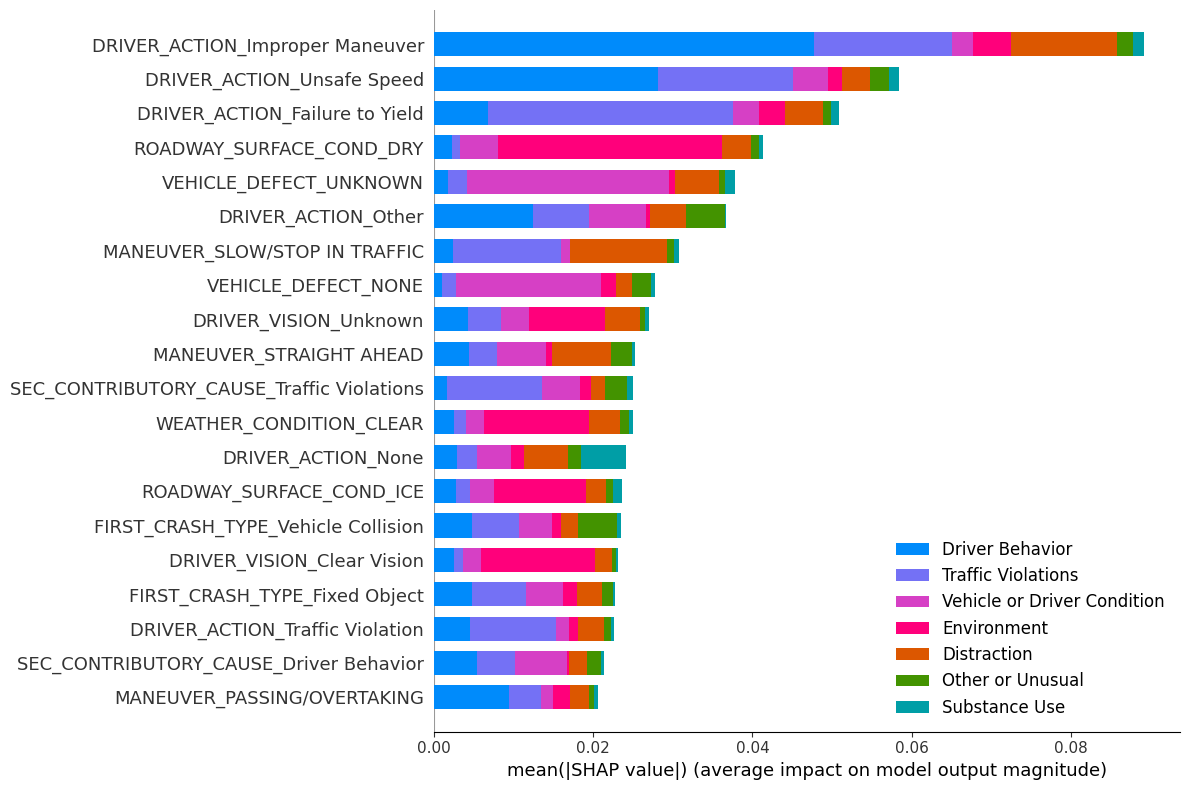

In [40]:
import shap

X_explain = X_test_processed[:500]
if hasattr(X_explain, "toarray"):
    X_explain = X_explain.toarray()

explainer = shap.KernelExplainer(model.predict, X_explain[:100])
shap_values = explainer.shap_values(X_explain[:100], nsamples=100)
shap.summary_plot(shap_values, X_explain[:100],plot_type="bar", feature_names=feature_names,class_names=class_names, plot_size=(12, 8) )